# Notebook to make Fig. 16

In [1]:
# Import necessary packages & set-up plotting aesthetics
import numpy as np 
import pylab
import pandas as pd
from scipy.stats import gaussian_kde
import json

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style

from fig_helper_functions import *

style.use('plotting.mplstyle')

import seaborn as sns
sns.set_palette('colorblind')

import sys
sys.path.append('./../Code/PopulationInference')
from posterior_helper_functions import mu_sigma2_to_a_b, calculate_betaDistribution, calculate_Double_Gaussian

### Data for true underlying populations

Load data

In [2]:
f_root = '../Data/InjectedPopulationParameters/' 
pop1 = pd.read_json(f_root+'underlying_population1_highSpinPrecessing_fullmassrange.json')
pop2 = pd.read_json(f_root+'underlying_population2_mediumSpin_fullmassrange.json')
pop3 = pd.read_json(f_root+'underlying_population3_lowSpinAligned_fullmassrange.json')

Make KDEs for spin parameters of underlying populations

In [3]:
# Set up grids to evaluate KDEs on
chi_grid = np.linspace(0,1,500)
cost_grid =  np.linspace(-1,1,500)
chieff_grid =  np.linspace(-1,1,500)
chip_grid =  np.linspace(0,1,500)

# Dict in which to store KDEs
kde_dict = {}

# Cycle through populations
for pop,pop_key in zip([pop1, pop2, pop3], ['pop 1', 'pop 2', 'pop 3']):
    
    # Use function in fig_helper_functions
    kde_dict[pop_key] = get_KDE_dict_spins(pop)

### Load `emcee` hierarchical inference results

Load data

In [4]:
# For loading files
model = 'betaPlusDoubleGaussian2'
pops = ['1', '2', '3']
posteriors = ['0', '492', '526', '738', '847', '929']
nevent = '70'

# Make Dict
data_dict = {}

# Cycle through the different populations and no. of events
for pop in pops: 
    data_pop = {}
    for seed in posteriors: 
        
        print(pop, seed)
        
        if seed=='0':
            name = f"103023_{model}_pop{pop}_{nevent}events"
        else: 
            name = f"103123_{model}_pop{pop}_{nevent}events_seed{seed}"
        
        with open(f'../Data/PopulationInferenceOutput/{model}/{name}.json', 'r') as f:
            data = json.load(f)
            
        data_pop[seed] = data    
            
    data_dict['pop '+pop] = data_pop

1 0
1 492
1 526
1 738
1 847
1 929
2 0
2 492
2 526
2 738
2 847
2 929
3 0
3 492
3 526
3 738
3 847
3 929


Make dict containing all the traces to plot

In [5]:
# Make dict 
traces_dict = {}

# Choose a number of traces to draw
nTracesMax = 1000

# Cycle through populations and numbers of events
for pop in pops: 
    
    pop_key = 'pop '+pop
    traces_pop = {}
        
    for posterior in posteriors:

        print(pop_key, posterior)

        # Fetch data
        data = data_dict[pop_key][posterior]

        # Instantiate an array to hold a collection of traces
        nTraces = min(nTracesMax, len(data['mu_chi']['processed']))
        p_chi = np.zeros((nTraces,chi_grid.size))
        p_cost = np.zeros((nTraces,cost_grid.size))
        p_chieff = np.zeros((nTraces,chieff_grid.size))
        p_chip = np.zeros((nTraces,chip_grid.size))

        # For a random set of posterior samples, compute and store the corresponding probability densities across our grid
        random_indices = np.random.choice(np.arange(len(data['mu_chi']['processed'])), size=nTraces,replace=False)
        for i,ind in enumerate(random_indices):

            print(i, end='\r')

            mu_chi = data['mu_chi']['processed'][ind]
            sigma_chi = data['sigma_chi']['processed'][ind]
            mu1_cost = data['mu1_cost']['processed'][ind]
            sigma1_cost = data['sigma1_cost']['processed'][ind]
            mu2_cost = data['mu2_cost']['processed'][ind]
            sigma2_cost = data['sigma2_cost']['processed'][ind]
            MF_cost = data['MF_cost']['processed'][ind]
            Bq = data['Bq']['processed'][ind]

            # calculate gaussian distribution for chi
            a,b = mu_sigma2_to_a_b(mu_chi, sigma_chi**2)
            p_chi[i,:] = calculate_betaDistribution(chi_grid, a, b)

            # and gaussian distribution for cos(theta)
            p_cost[i,:] = calculate_Double_Gaussian(cost_grid, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, -1, 1)

            # generate corresponding distribution for chi_eff and chi_p
            chi_effs, chi_ps = draw_chiEffs_and_chiPs_betaDoubleGauss(mu_chi, sigma_chi, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, Bq, 
                                                                      mCut=8, n=500)

            chieff_kde = gaussian_kde(chi_effs)
            p_chieff[i,:] = chieff_kde(chieff_grid)

            chip_kde = gaussian_kde(chi_ps)
            p_chip[i,:] = chip_kde(chip_grid)

        # Add to dict 
        traces_pop[posterior] = {'p_chi':p_chi, 'p_cost':p_cost, 'p_chieff':p_chieff, 'p_chip':p_chip} 
                
    traces_dict[pop_key] = traces_pop

pop 1 0


/home/simona.miller/measuring-bbh-component-spin/Code/GeneratePopulations/helper_functions.py:203: RuntimeWarning: overflow encountered in exp
  f = np.exp(deltaM/m + deltaM/(m-deltaM))


pop 1 492
pop 1 526
pop 1 738
pop 1 847
pop 1 929
pop 2 0
pop 2 492
pop 2 526
pop 2 738
pop 2 847
pop 2 929
pop 3 0
pop 3 492
pop 3 526
pop 3 738
pop 3 847
pop 3 929


### Make figure

In [6]:
# Labels corresponding to each pop
labels_dict = {
    'pop 1':r'$\mathrm{\textsc{HighSpin}}$'+'\n'+r'$\mathrm{\textsc{Precessing}}$', 
    'pop 2':r'$\mathrm{\textsc{MediumSpin}}$', 
    'pop 3':r'$\mathrm{\textsc{LowSpin}}$'+'\n'+r'$\mathrm{\textsc{Aligned}}$'
}

# Colors corresponding to different numbers of events
colors_dict = {
    s:f'C{i}' for i,s in enumerate(posteriors)
}

label_kws = dict(fontsize=17, zorder=5)

/home/simona.miller/.conda/envs/emcee/lib/python3.6/site-packages/ipykernel_launcher.py:102: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/simona.miller/.conda/envs/emcee/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator


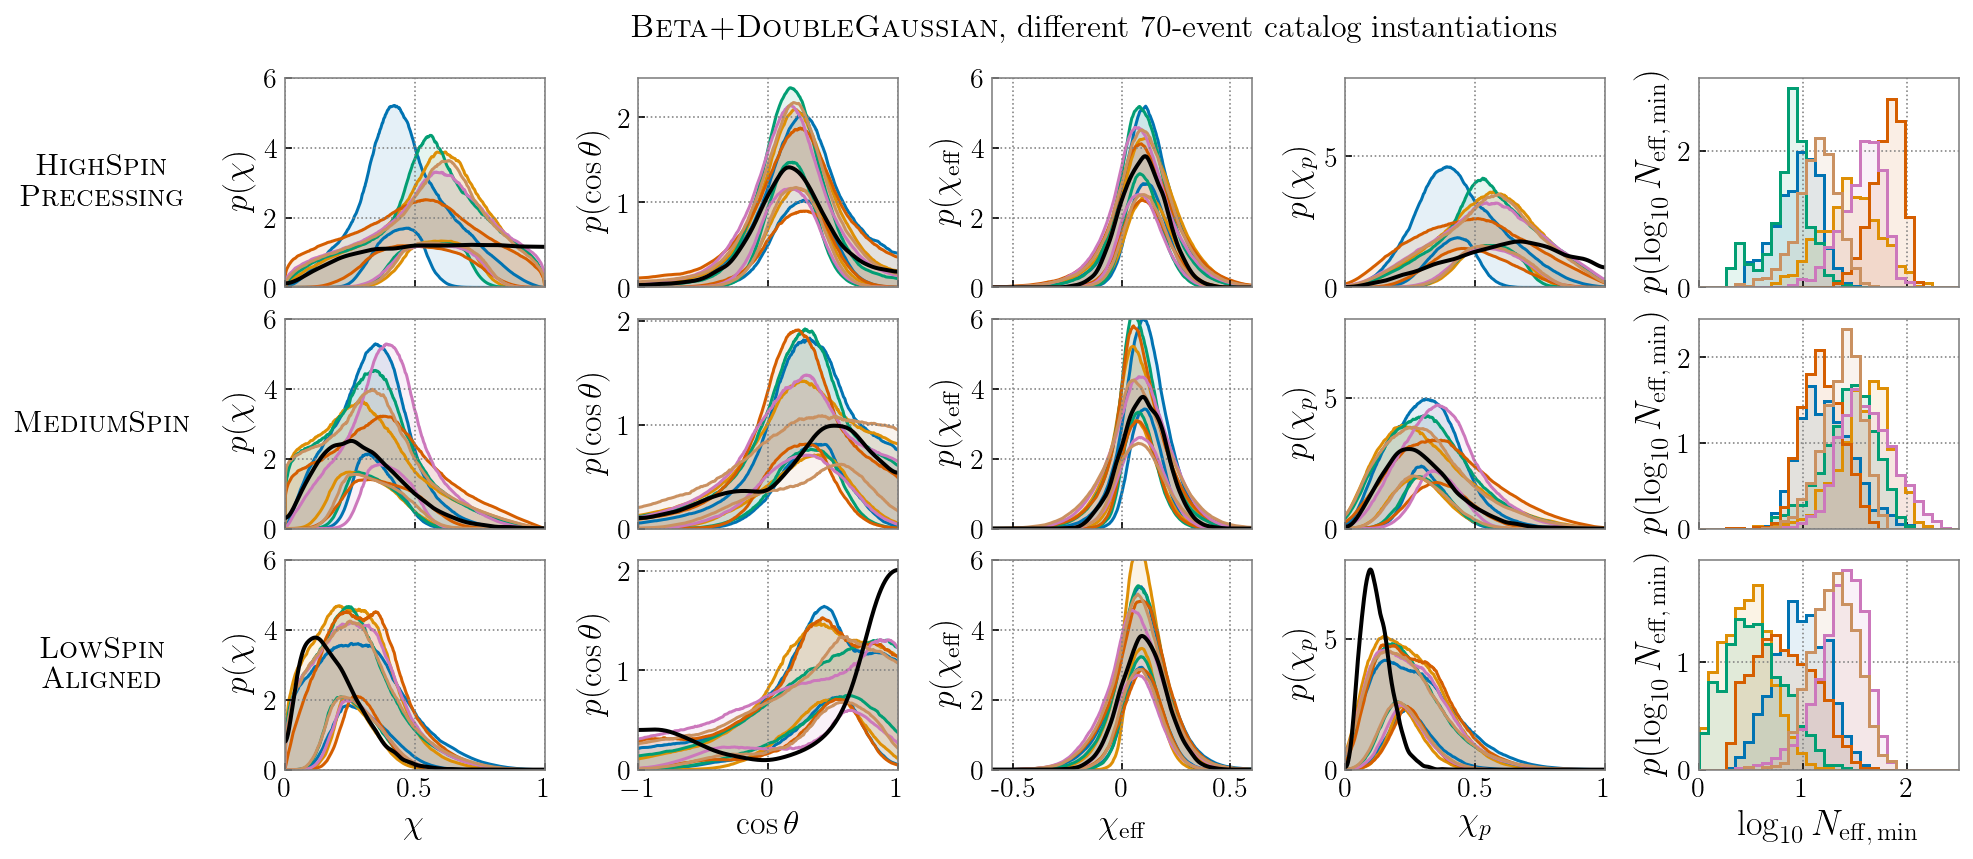

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7/1.1))

for ax in axes: 
    for a in ax: 
        a.set_rasterization_zorder(2)

for i,pop_key in enumerate(kde_dict):
    for j,posterior in enumerate(posteriors):

        # plotting kws 
        kws = dict(color=colors_dict[posterior], zorder=1)
        alph = 0.1

        ## Plot 5% and 95% credible bounds

        # spin magnitude
        p_chi = traces_dict[pop_key][posterior]['p_chi']
        chi_quants = np.quantile(p_chi, (0.05, 0.95), axis=0)
        axes[i][0].plot(chi_grid, chi_quants[0], **kws)
        axes[i][0].plot(chi_grid, chi_quants[1], **kws)
        axes[i][0].fill_between(chi_grid, chi_quants[0], y2=chi_quants[1],**kws, alpha=alph)

        # tilt angle
        p_cost = traces_dict[pop_key][posterior]['p_cost']
        cost_quants = np.quantile(p_cost, (0.05, 0.95), axis=0)
        axes[i][1].plot(cost_grid, cost_quants.T, **kws)
        axes[i][1].fill_between(cost_grid, cost_quants[0], y2=cost_quants[1],**kws, alpha=alph)

        # chi effective
        p_chieff = traces_dict[pop_key][posterior]['p_chieff']
        chieff_quants = np.quantile(p_chieff, (0.05, 0.95), axis=0)
        axes[i][2].plot(chieff_grid, chieff_quants.T, **kws)
        axes[i][2].fill_between(chieff_grid, chieff_quants[0], y2=chieff_quants[1],**kws, alpha=alph)

        # chi p
        p_chip = traces_dict[pop_key][posterior]['p_chip']
        chip_quants = np.quantile(p_chip, (0.05, 0.95), axis=0)
        axes[i][3].plot(chip_grid, chip_quants.T, **kws)
        axes[i][3].fill_between(chip_grid, chip_quants[0], y2=chip_quants[1],**kws, alpha=alph)
               
    ## Plot injected dists 
    
    # spin magnitude
    axes[i][0].plot(chi_grid, kde_dict[pop_key]['chi'], color='k', lw=2, label='true population')
    axes[i][0].set_xlim(0,1)
    axes[i][0].set_ylim(0,)
    
    # tilt angle
    axes[i][1].plot(cost_grid, kde_dict[pop_key]['cost'], color='k', lw=2)
    axes[i][1].set_xlim(-1,1)
    
    # chi effective
    axes[i][2].plot(chieff_grid, kde_dict[pop_key]['chieff'], color='k', lw=2)
    axes[i][2].set_xlim(-0.6,0.6)
    axes[i][2].set_ylim(0,11)
    
    # chi p
    axes[i][3].plot(chip_grid, kde_dict[pop_key]['chip'], color='k', lw=2)
    axes[i][3].set_xlim(0,1)
    axes[i][3].set_ylim(0,11)
    
    # y-axis labels
    axes[i][0].set_ylabel(r'$p(\chi)$', **label_kws)
    axes[i][1].set_ylabel(r'$p(\cos\theta)$', **label_kws)
    axes[i][2].set_ylabel(r'$p(\chi_\mathrm{eff})$', **label_kws)
    axes[i][3].set_ylabel(r'$p(\chi_p)$', **label_kws)  
    
    # set pop label
    axes[i][0].text(-0.7, 0.5, labels_dict[pop_key], fontsize=15, transform=axes[i][0].transAxes,
                    horizontalalignment='center', verticalalignment='center')
    
    axes[i][0].set_ylim(0,6)
    
    if i!=2: 
        for ax in axes[i]: 
            ax.set_xticklabels([])

# x-axis labels
axes[2][0].set_xlabel(r'$\chi$', **label_kws)
axes[2][1].set_xlabel(r'$\cos\theta$', **label_kws)
axes[2][2].set_xlabel(r'$\chi_\mathrm{eff}$', **label_kws)
axes[2][3].set_xlabel(r'$\chi_p$', **label_kws)  

# Set y limits
for a in axes.T[0]:
    a.set_ylim(0, )
for a in axes.T[1]:
    a.set_ylim(0, )
for a in axes.T[2]: 
    a.set_ylim(0,6)
for a in axes.T[3]: 
    a.set_ylim(0,8)

for ax in axes:
    for a in ax:
        a.spines['bottom'].set_color('gray')
        a.spines['top'].set_color('gray') 
        a.spines['right'].set_color('gray')
        a.spines['left'].set_color('gray')
        
        
axes[2][0].set_xticklabels([int(0), 0.5, int(1)])
axes[2][2].set_xticks([-0.5, int(0), 0.5])
axes[2][2].set_xticklabels([-0.5, int(0), 0.5])
axes[2][3].set_xticklabels([int(0), 0.5, int(1)])


# Add in column 5: hists of min(Neff)
for i,pop_key in enumerate(kde_dict):
    for posterior in posteriors:

        # Fetch Neffs
        Neffs = data_dict[pop_key][posterior]['minNsamps']
        
        # Histogram 
        bins = np.linspace(0,2.5,30)
        hist_kws = dict(density=True, bins=bins, color=colors_dict[posterior], lw=1.5)
        axes[i][-1].hist(np.log10(Neffs), **hist_kws, histtype='step')
        axes[i][-1].hist(np.log10(Neffs), **hist_kws, alpha=0.1)
        
    axes[i][-1].set_ylabel(r'$p(\log_{10} N_\mathrm{eff,\,min})$')
    axes[i][-1].set_xlim(0, 2.5)

axes[-1][-1].set_xlabel(r'$\log_{10} N_\mathrm{eff,\,min}$')


# Add in title
plt.suptitle(r'$\mathrm{\textsc{Beta+DoubleGaussian}}$, different 70-event catalog instantiations', 
             fontsize=16, y=0.95)

# Final adjustments
plt.subplots_adjust(hspace=0.15, wspace=0.36)
    
plt.savefig('figure_16.pdf',bbox_inches='tight')
plt.show()